In [1]:
import numpy as np


def smooth_filter(arr, size=5):
    """
    Apply a strict nanmean filter to a 2D array:
    - For each point, if more than one of the neighbors is NaN, return NaN.
    - Otherwise, return the nanmean of neighbors.
    
    Parameters:
        arr: 2D numpy array
        size: int, either 5 (cross-shaped) or 9 (3x3 square)
    
    Returns:
        2D numpy array with the filter applied.
    """
    arr = np.asarray(arr)
    if arr.ndim != 2:
        raise ValueError("Input array must be 2-dimensional.")
    if size not in (5, 9):
        raise ValueError("Size must be 5 or 9.")

    result = arr.copy()
    nrows, ncols = arr.shape

    for i in range(nrows):
        for j in range(ncols):
            if np.isnan(arr[i, j]):
                continue
            neighbors = []

            if size == 5:
                coords = [(i, j),
                          (i-1, j), (i+1, j),
                          (i, j-1), (i, j+1)]
            elif size == 9:
                coords = [(ii, jj)
                          for ii in range(i-1, i+2)
                          for jj in range(j-1, j+2)]

            for ii, jj in coords:
                if 0 <= ii < nrows and 0 <= jj < ncols:   #A way to deal with the borders
                    neighbors.append(arr[ii, jj])
                else:
                    neighbors.append(np.nan)

            if np.isnan(neighbors).sum() > 2:
                result[i, j] = np.nan
            else:
                result[i, j] = np.nanmean(neighbors)

    return result

In [2]:
work_place = "hydra" # 'hydra', 'ubuntu' or 'win'
if work_place == 'hydra':
    base_path = r'/home/jorge.gacitua/salidas/L96_multiple_experiments/data/LETKF'
    output_dir = r'/home/jorge.gacitua/salidas/L96_multiple_experiments/figures'
elif work_place == 'ubuntu':
    base_path = r'/media/jgacitua/storage/L96_multiple_experiments/data/LETKF'
    output_dir = r'/media/jgacitua/storage/L96_multiple_experiments/figures'
elif work_place == 'win':
    base_path  = r'C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\data\LETKF'
    output_dir = r'C:\Users\jyndd\OneDrive\Doctorado\Experimentos\L96_multiple_experiments\figures'

In [3]:
import numpy as np
import os
import common_function as cf

Freq = 4
Den = 1.0
ObseErr = '5'
nens_labels = np.array([10, 20, 40, 60, 80,100])
assim_labels = np.array([10, 20, 40, 60, 80])
alpha_range = np.array([2])
n_ens = len(nens_labels)
n_assim = len(assim_labels)


gec = 'NOGEC'


for k, method_idx in enumerate([0, 1, 2]):  # LETKF, T2, T3
    rmse_values = np.empty((n_assim, n_ens, 3))  # 3 methods: LETKF, T2, T3
    best_inflation = np.empty((n_assim, n_ens, 3))  # 3 methods: LETKF, T2, T3
    best_localization = np.empty((n_assim, n_ens, 3))
    
    for iassim, assim in enumerate(assim_labels):
        for inens, nens in (enumerate(nens_labels)):
            filename = f"LETKF_Paper_Nature_Freq{Freq}_Den{Den}_Type3_ObsErr{ObseErr}_Nens{nens}_NTemp{method_idx+1}_alpha2_{gec}_{assim}k.npz"
            filepath = os.path.join(base_path, filename)

            if os.path.exists(filepath):
                data = np.load(filepath, allow_pickle=True)
                rmse = data['total_analysis_rmse']
                NormalEnd = 1 - data['NormalEnd']
                NormalEnd = NormalEnd.astype(bool)
                rmse[NormalEnd] = np.nan
                rmse = cf.outlier_rmse_filter(rmse)

                # Apply smoothing
                rmse_smooth = smooth_filter(rmse, size=5)
                rmse_values[iassim, inens, k] = np.nanmin(rmse_smooth)
            else:
                print(f'Not found for {filename}')
                rmse_values[iassim, inens, k] = np.nan

np.savez(os.path.join(base_path, f"rmse_values_smooth_Freq{Freq}_Den{Den}_ObsErr{ObseErr}_alpha_{gec}.npz"),
            rmse_values=rmse_values, assim_labels=assim_labels, nens_labels=nens_labels)
print(f"file saved: rmse_values_smooth_Freq{Freq}_Den{Den}_ObsErr{ObseErr}_nens{nens}_{gec}.npz")
print("Data saved successfully.")
#rmse_values_smooth_Freq4_Den1.0_ObsErr5_NOGEC_nens10_80k.npz

file saved: rmse_values_smooth_Freq4_Den1.0_ObsErr5_nens100_NOGEC.npz
Data saved successfully.


In [4]:
import numpy as np
import os
import common_function as cf

# Parameters
Freq = 4
Den = 1.0
ObseErr = '5'
nens_labels = np.array([10, 20, 40, 60, 80, 100])
assim_labels = np.array([10, 20, 40, 60, 80])  # in thousands of cycles
alpha_range = np.array([2])  # not used here but keep for consistency
gec = 'NOGEC'

n_ens = len(nens_labels)
n_assim = len(assim_labels)


# Final array: (assim_length, nens, method)
rmse_values = np.full((n_assim, n_ens, 3), np.nan)  # 3 methods: LETKF, T2, T3

for k, method_idx in enumerate([0, 1, 2]):  # LETKF, T2, T3
    for iassim, assim in enumerate(assim_labels):
        for inens, nens in enumerate(nens_labels):

            filename = (
                f"LETKF_Paper_Nature_Freq{Freq}_Den{Den}_Type3_ObsErr{ObseErr}"
                f"_Nens{nens}_NTemp{method_idx+1}_alpha2_{gec}_{assim}k.npz"
            )
            filepath = os.path.join(base_path, filename)

            if os.path.exists(filepath):
                data = np.load(filepath, allow_pickle=True)
                rmse = data['total_analysis_rmse']

                # Apply filtering
                NormalEnd = 1 - data['NormalEnd']
                NormalEnd = NormalEnd.astype(bool)
                rmse[NormalEnd] = np.nan
                rmse = cf.outlier_rmse_filter(rmse)

                # Smooth
                rmse_smooth = smooth_filter(rmse, size=5)

                # Store best RMSE
                rmse_values[iassim, inens, k] = np.nanmin(rmse_smooth)

            else:
                print(f'Not found: {filename}')

# Save single compact file with all results
outfile = os.path.join(
    base_path,
    f"rmse_values_smooth_Freq{Freq}_Den{Den}_ObsErr{ObseErr}_alpha_{gec}.npz"
)

np.savez(
    outfile,
    rmse_values=rmse_values,
    assim_labels=assim_labels,
    nens_labels=nens_labels
)

print(f"Data saved successfully in {outfile}")


Data saved successfully in /home/jorge.gacitua/salidas/L96_multiple_experiments/data/LETKF/rmse_values_smooth_Freq4_Den1.0_ObsErr5_alpha_NOGEC.npz


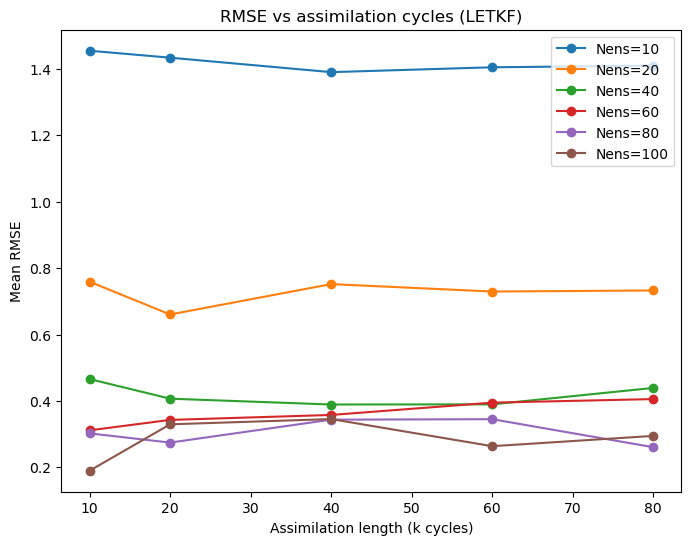

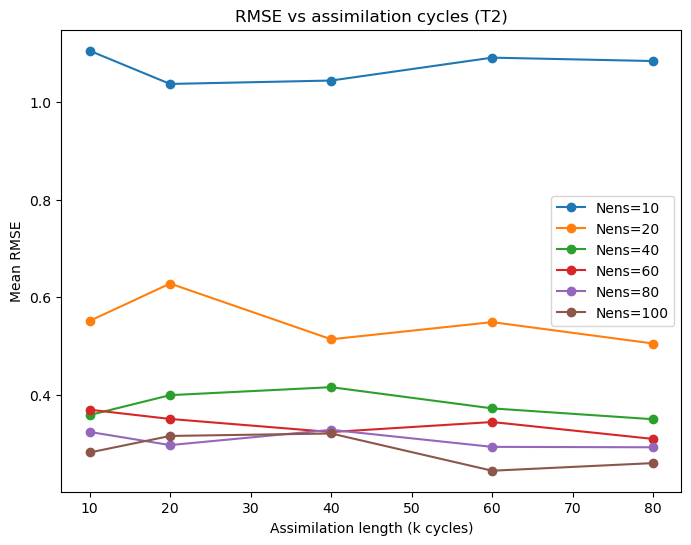

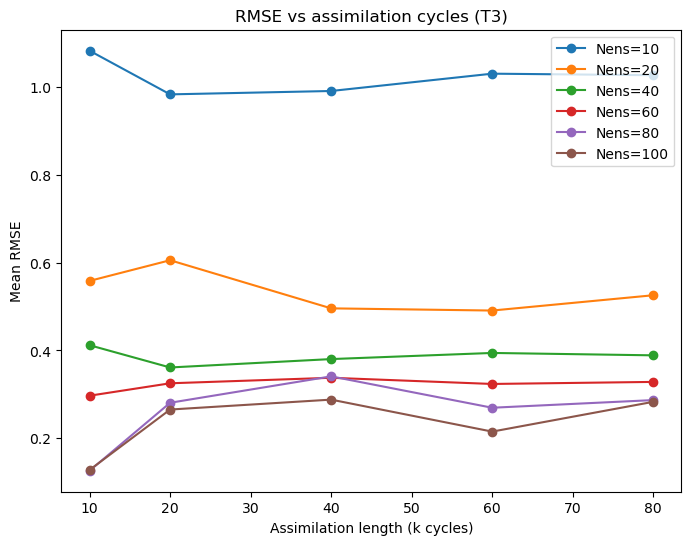

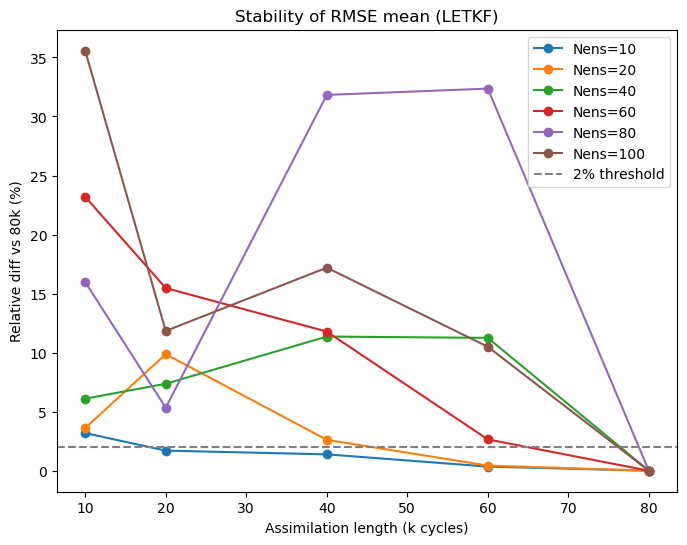

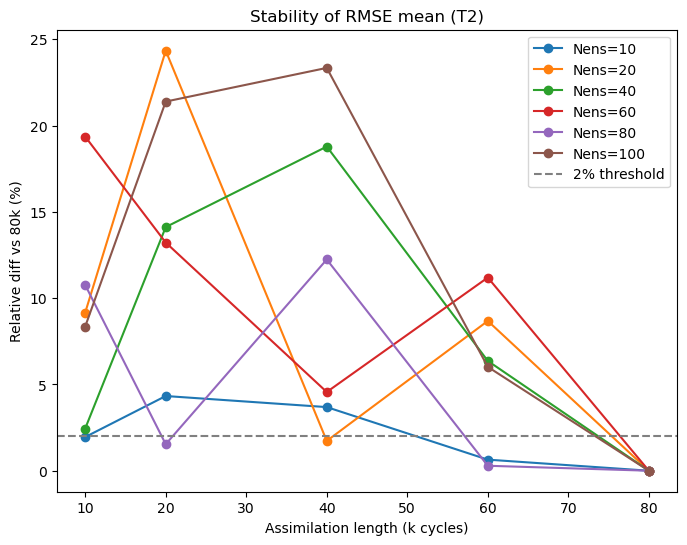

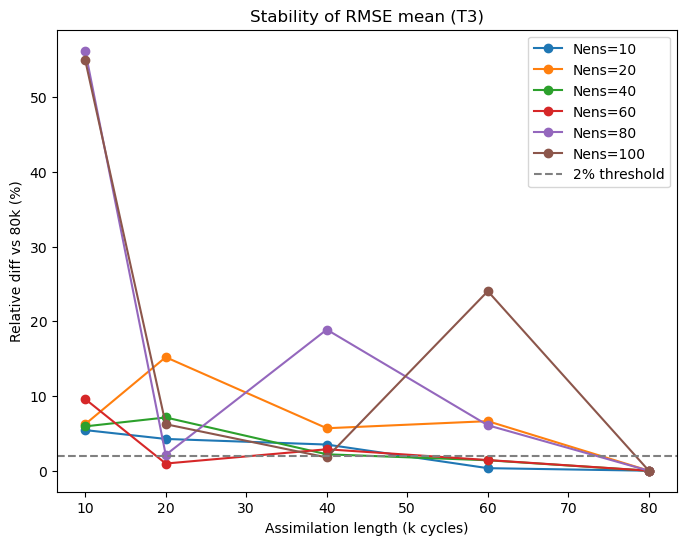

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load the preprocessed data
data = np.load(os.path.join(base_path,"rmse_values_smooth_Freq4_Den1.0_ObsErr5_alpha_NOGEC.npz"))
rmse_values = data["rmse_values"]   # shape (n_assim, n_ens, 3)
assim_labels = data["assim_labels"]
nens_labels = data["nens_labels"]

methods = ["LETKF", "T2", "T3"]

# 1. RMSE vs Assimilation cycles for each method and ensemble size
for k, method in enumerate(methods):
    plt.figure(figsize=(8,6))
    for j, nens in enumerate(nens_labels):
        plt.plot(assim_labels, rmse_values[:, j, k], marker='o', label=f"Nens={nens}")
    plt.xlabel("Assimilation length (k cycles)")
    plt.ylabel("Mean RMSE")
    plt.title(f"RMSE vs assimilation cycles ({method})")
    plt.legend()
    plt.show()

# 2. Relative difference wrt longest run (80k)
longest_idx = np.argmax(assim_labels)
for k, method in enumerate(methods):
    plt.figure(figsize=(8,6))
    for j, nens in enumerate(nens_labels):
        rmse_long = rmse_values[longest_idx, j, k]
        rel_diff = np.abs(rmse_values[:, j, k] - rmse_long) / rmse_long * 100
        plt.plot(assim_labels, rel_diff, marker='o', label=f"Nens={nens}")
    plt.xlabel("Assimilation length (k cycles)")
    plt.ylabel("Relative diff vs 80k (%)")
    plt.title(f"Stability of RMSE mean ({method})")
    plt.axhline(2, color="gray", linestyle="--", label="2% threshold")
    plt.legend()
    plt.show()


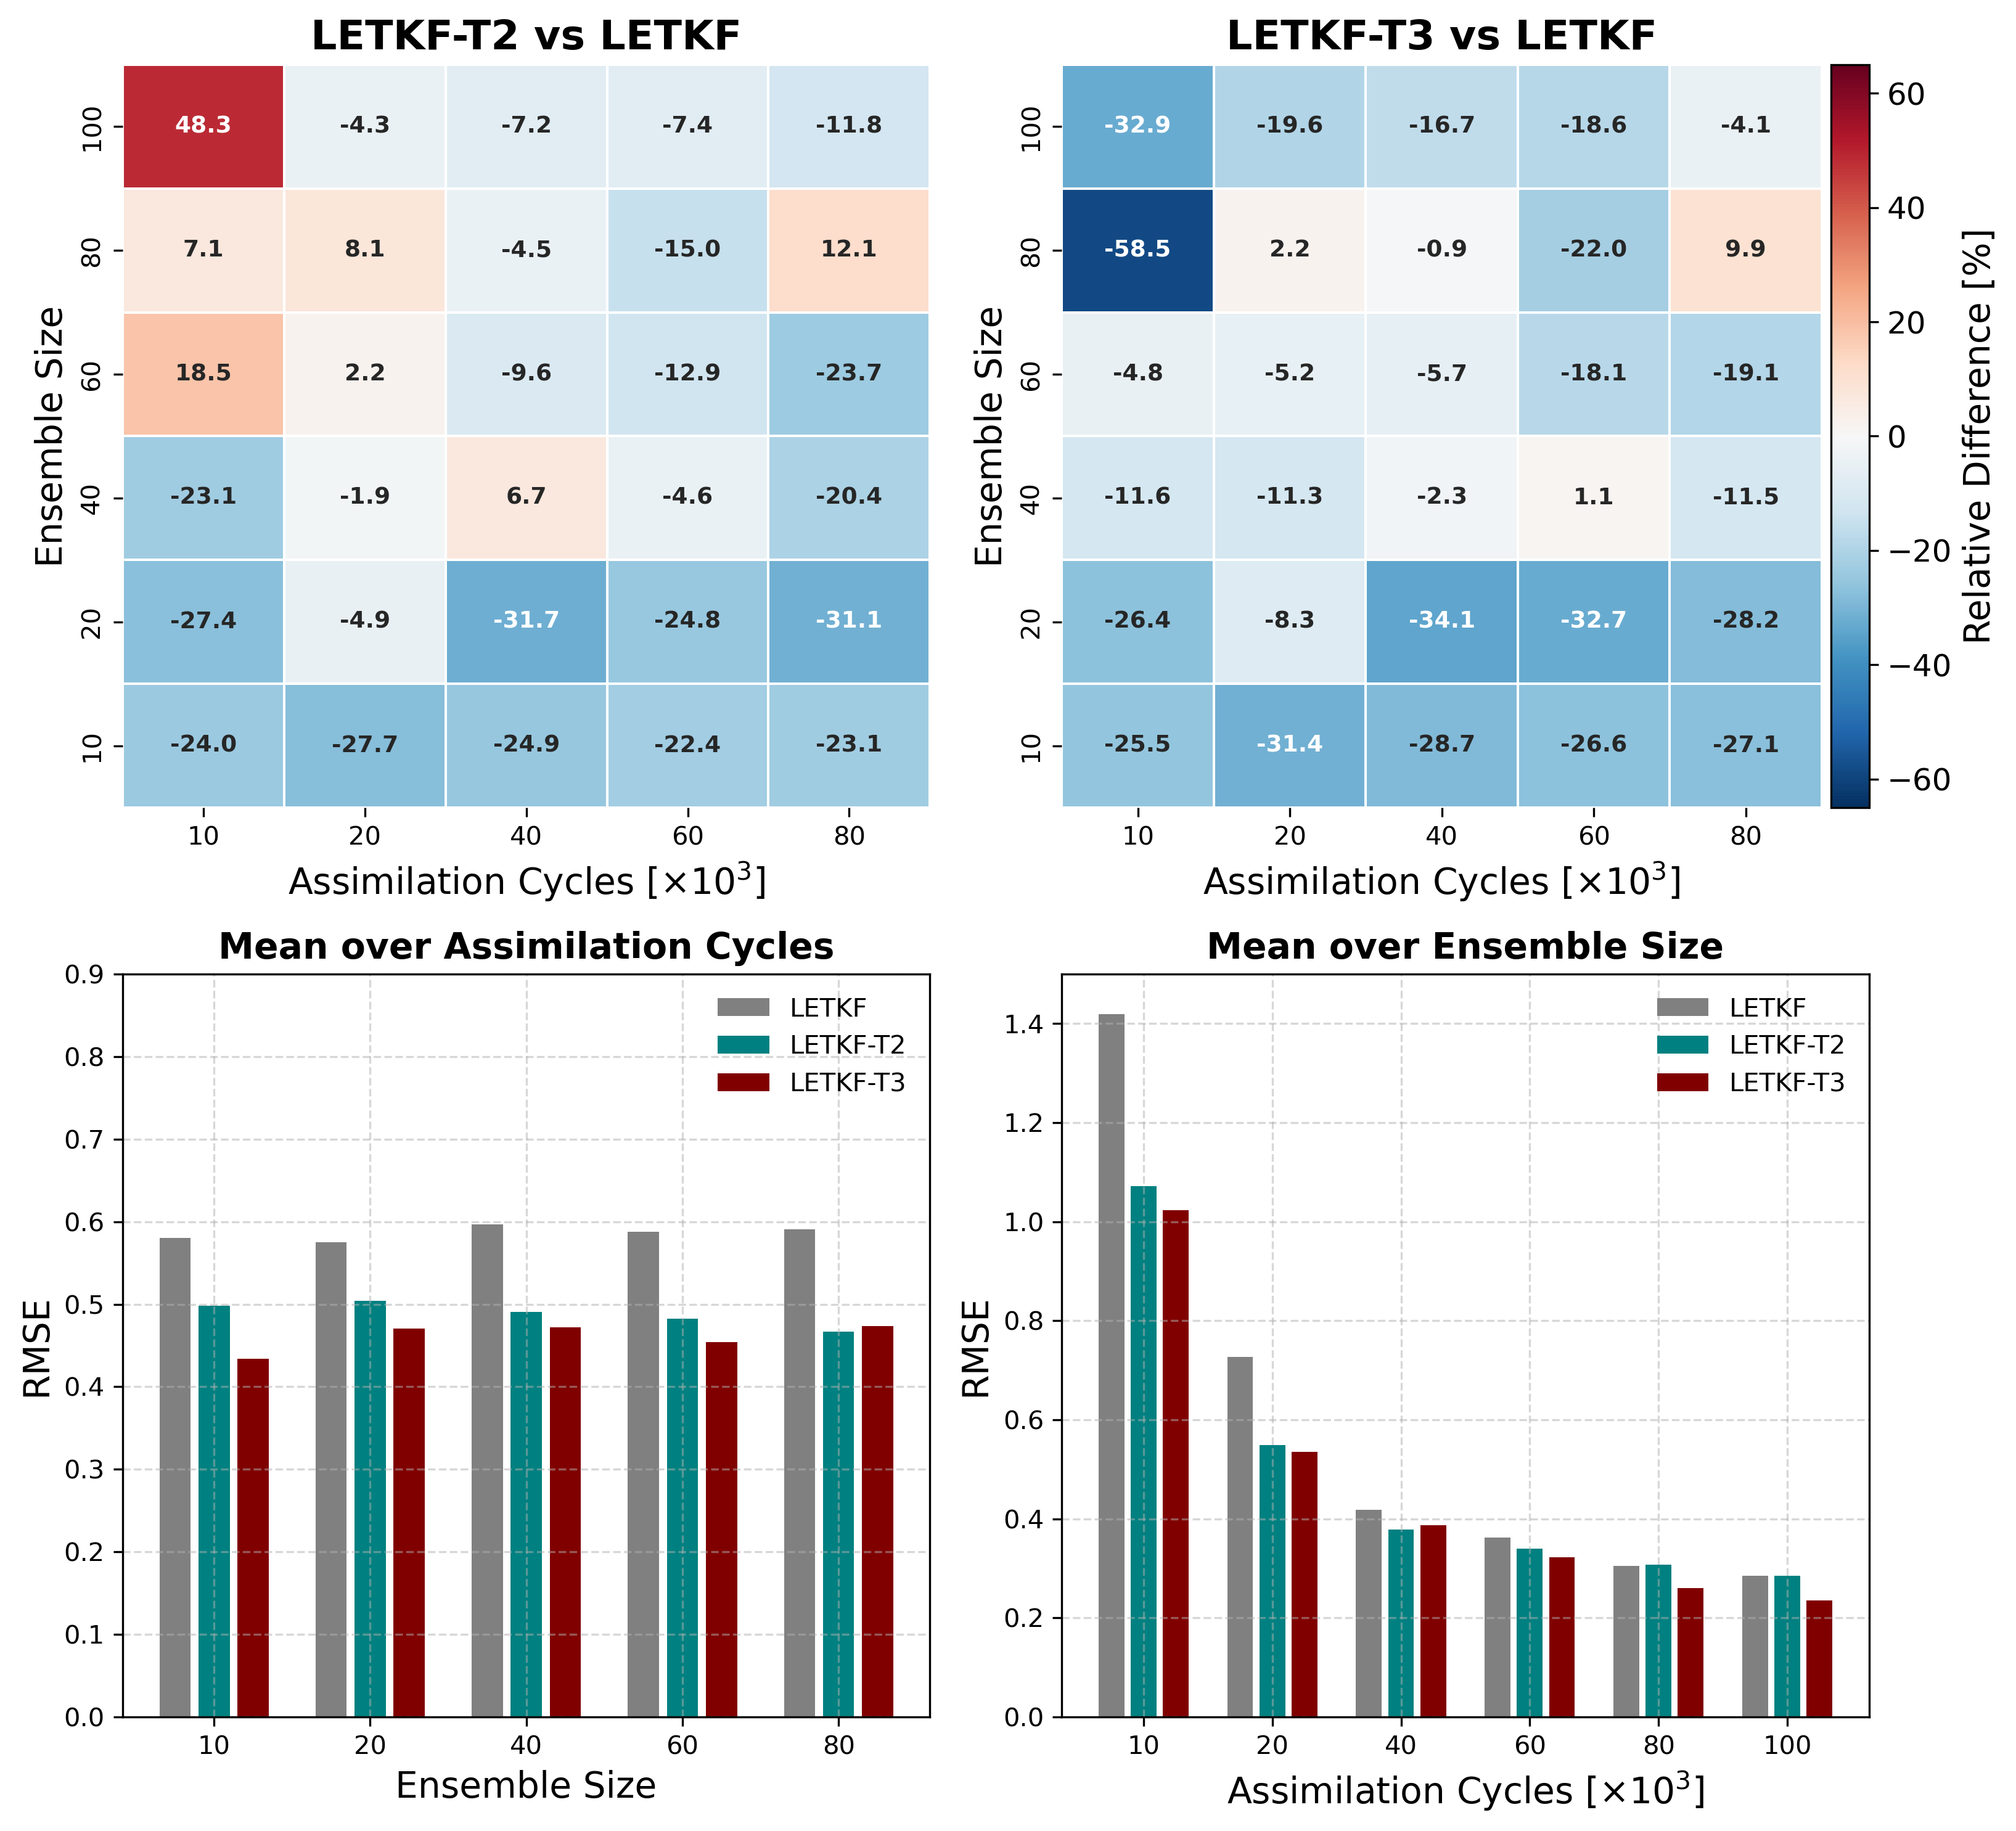

Figures saved to: /home/jorge.gacitua/salidas/L96_multiple_experiments/figures


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

# === SETTINGS ===
Freq = 4
Den = 1.0
ObseErr = 5
gec = 'NOGEC'


# Single aggregated file
filename = f'rmse_values_smooth_Freq{Freq}_Den{Den}_ObsErr{ObseErr}_alpha_{gec}.npz'
filepath = os.path.join(base_path, filename)

# === LOAD DATA ===
data = np.load(filepath)
rmse_values_smooth = data['rmse_values']  # shape (n_assim, n_ens, 3)
assim_labels = data["assim_labels"]
nens_labels = data["nens_labels"]

# Split LETKF, LETKF-T2, LETKF-T3
letkf    = rmse_values_smooth[:, :, 0]
letkf_t2 = rmse_values_smooth[:, :, 1]
letkf_t3 = rmse_values_smooth[:, :, 2]

# === % change relative to LETKF ===
pct_t2 = ((letkf_t2 - letkf) / letkf) * 100
pct_t3 = ((letkf_t3 - letkf) / letkf) * 100

# === PLOTTING ===
fig, axes = plt.subplots(2, 2, figsize=(11, 10), dpi=300)
axes = axes.flatten()

# Panel 1 – RMSE vs ensemble size (mean over alpha)
mean_rmse_letkf    = np.mean(letkf, axis=1)
mean_rmse_letkf_t2 = np.mean(letkf_t2, axis=1)
mean_rmse_letkf_t3 = np.mean(letkf_t3, axis=1)

axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].bar(np.arange(len(assim_labels))*4,   mean_rmse_letkf,    color='gray',   label='LETKF')
axes[2].bar(np.arange(len(assim_labels))*4+1, mean_rmse_letkf_t2, color='teal',   label='LETKF-T2')
axes[2].bar(np.arange(len(assim_labels))*4+2, mean_rmse_letkf_t3, color='maroon', label='LETKF-T3')

axes[2].set_xticks(np.arange(len(assim_labels))*4+1)
axes[2].set_xticklabels(assim_labels)
axes[2].set_ylabel("RMSE", fontsize=14)
axes[2].set_xlabel("Ensemble Size", fontsize=14)
axes[2].set_title("Mean over Assimilation Cycles", fontsize=14, fontweight='bold')
axes[2].set_ylim(0, 0.9)
axes[2].legend(loc='upper right', fontsize=10, frameon=False)

# Panel 2 – RMSE vs alpha (mean over ensemble size)
mean_rmse_letkf    = np.mean(letkf, axis=0)
mean_rmse_letkf_t2 = np.mean(letkf_t2, axis=0)
mean_rmse_letkf_t3 = np.mean(letkf_t3, axis=0)

axes[3].grid(True, linestyle='--', alpha=0.5)
axes[3].bar(np.arange(len(nens_labels))*4,   mean_rmse_letkf,    color='gray',   label='LETKF')
axes[3].bar(np.arange(len(nens_labels))*4+1, mean_rmse_letkf_t2, color='teal',   label='LETKF-T2')
axes[3].bar(np.arange(len(nens_labels))*4+2, mean_rmse_letkf_t3, color='maroon', label='LETKF-T3')

axes[3].set_xticks(np.arange(len(nens_labels))*4+1)
axes[3].set_xticklabels(nens_labels)
axes[3].set_ylabel("RMSE", fontsize=14)
axes[3].set_xlabel("Assimilation Cycles $[\\times 10^3]$", fontsize=14)
axes[3].set_title("Mean over Ensemble Size", fontsize=14, fontweight='bold')
axes[3].set_ylim(0, 1.5)
axes[3].legend(loc='upper right', fontsize=10, frameon=False)

# Panel 3 – Heatmap T2 vs LETKF
vmin, vmax = -65., 65.0
hm_t2 = sns.heatmap(pct_t2.T, annot=True, fmt=".1f", cmap="RdBu_r", center=0,
                    vmin=vmin, vmax=vmax, xticklabels=assim_labels, yticklabels=nens_labels,
                    ax=axes[0], cbar=False, linewidths=.5, annot_kws={"fontsize": 9, "fontweight": "bold"})

axes[0].set_title("LETKF-T2 vs LETKF", fontsize=16, fontweight='bold')
axes[0].set_ylabel("Ensemble Size", fontsize=14)
axes[0].set_xlabel("Assimilation Cycles $[\\times 10^3]$", fontsize=14)
axes[0].invert_yaxis()

# Panel 4 – Heatmap T3 vs LETKF
hm_t3 = sns.heatmap(pct_t3.T, annot=True, fmt=".1f", cmap="RdBu_r", center=0,
                    vmin=vmin, vmax=vmax, xticklabels=assim_labels, yticklabels=nens_labels,
                    ax=axes[1], cbar=False, linewidths=.5, annot_kws={"fontsize": 9, "fontweight": "bold"})

axes[1].set_title("LETKF-T3 vs LETKF", fontsize=16, fontweight='bold')
axes[1].set_ylabel("Ensemble Size", fontsize=14)
axes[1].set_xlabel("Assimilation Cycles $[\\times 10^3]$", fontsize=14)
axes[1].invert_yaxis()

# Add shared colorbar
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(hm_t3.collections[0], cax=cax)
cbar.set_label("Relative Difference [%]", fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.tight_layout()

# Save
os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_compare_Freq{Freq}_Den{Den}_ObsErr{ObseErr}_{gec}"
#plt.savefig(os.path.join(output_dir, f"{figname}.pdf"), dpi=300, bbox_inches='tight')
#plt.savefig(os.path.join(output_dir, f"{figname}.png"), dpi=300, bbox_inches='tight')
plt.show()

print("Figures saved to:", output_dir)



Figure saved as: 
 PDF: /home/jorge.gacitua/salidas/L96_multiple_experiments/figures/Figure_ObsError_Sensitivity_Nens80_Freq4_Den1.0_Type3_PTemp2_NOGEC.pdf 
 PNG: /home/jorge.gacitua/salidas/L96_multiple_experiments/figures/Figure_ObsError_Sensitivity_Nens80_Freq4_Den1.0_Type3_PTemp2_NOGEC.png


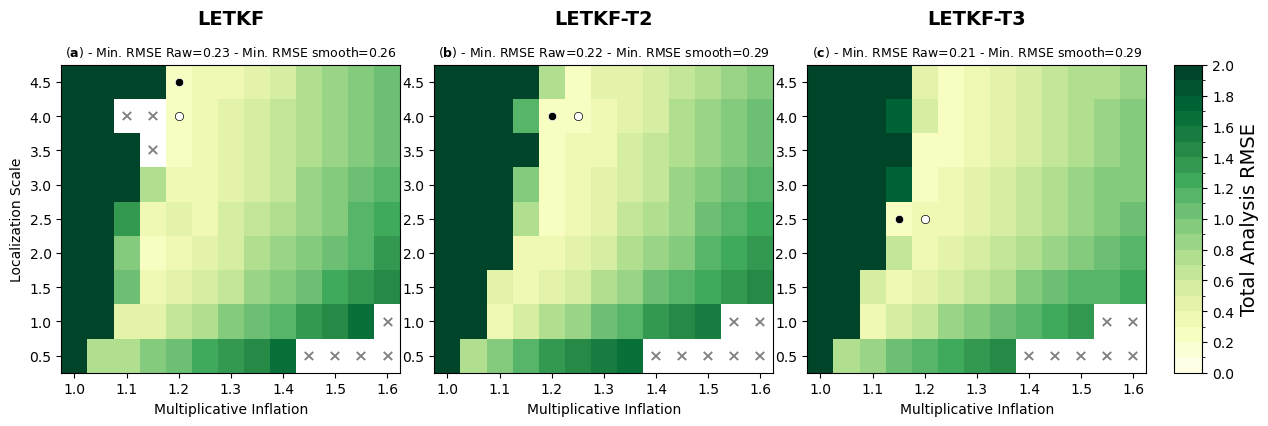

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import common_function as cf
import matplotlib.colors as mcolors
# Configuración
obs_errs = ['5']
ntemps = [1, 2, 3]
labels = ['LETKF', 'LETKF-T2', 'LETKF-T3']


nens = 80
freq = 4
den = 1.0
alpha = 2
gec = '_NOGEC'
assim = '80'  # in thousands of cycles
fig, axes = plt.subplots(len(obs_errs), len(ntemps), figsize=(14, 4), 
                         sharex=False, sharey=False, 
                         gridspec_kw={'hspace': 0.25, 'wspace': 0.1})


cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])  # x, y, width, height

vmin, vmax = 0, 2
panel_label_counter = 0

for i, obs in enumerate(obs_errs):
    for j, ntemp in enumerate(ntemps):
        filename = f"LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{obs}_Nens{nens}_NTemp{ntemp}_alpha2{gec}_{assim}k.npz"
        #filename = f'LETKF_Paper_Nature_Freq{freq}_Den{den}_Type3_ObsErr{obs}_Nens{nens}_NTemp{ntemp}_alpha{alpha}{gec}.npz'
        filepath = os.path.join(base_path, filename)

        ax = axes[ j]

        if os.path.exists(filepath):
            data = np.load(filepath, allow_pickle=True)
            #results = data['results']
            mult_inf_range = data['mult_inf_range']
            loc_scale_range = data['loc_scale_range']
            #print(data['AlphaTempList'])
            total_analysis_rmse = data['total_analysis_rmse']

            NormalEnd = 1 - data['NormalEnd']
            NormalEnd = NormalEnd.astype(bool)
            total_analysis_rmse[NormalEnd] = np.nan
            total_analysis_rmse = cf.outlier_rmse_filter( total_analysis_rmse )

            min_rmse = np.nanmin(total_analysis_rmse)
            idx_min = np.where(total_analysis_rmse == min_rmse)
            best_mult_inf = mult_inf_range[idx_min[0][0]]
            best_loc_scale = loc_scale_range[idx_min[1][0]]

            total_analysis_rmse_smooth = smooth_filter(total_analysis_rmse, size=5)
            
            min_rmse_smooth = np.nanmin(total_analysis_rmse_smooth)
            idx_min_smooth = np.where(total_analysis_rmse_smooth == min_rmse_smooth)
            best_mult_inf_smooth = mult_inf_range[idx_min_smooth[0][0]]
            best_loc_scale_smooth = loc_scale_range[idx_min_smooth[1][0]]

            #im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse.T, 
            #                    vmin=vmin, vmax=vmax, cmap='PuBu',edgecolors='lightgray',linewidth=0.001)
            levels = np.arange(0, 2.1, 0.1)  # From 0 to 2, step 0.25
            norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)

            im = ax.pcolormesh(mult_inf_range, loc_scale_range, total_analysis_rmse.T,
                            cmap='YlGn', norm=norm, edgecolors='lightgray', linewidth=0.001)            
            ax.plot(best_mult_inf, best_loc_scale, 'k.', markersize=12, markeredgecolor='white',markeredgewidth=0.5)
            ax.plot(best_mult_inf_smooth, best_loc_scale_smooth, 'w.', markersize=12, markeredgecolor='black',markeredgewidth=0.5)

            nan_mask = np.isnan(total_analysis_rmse.T)
            for (y, x), is_nan in np.ndenumerate(nan_mask):
                if is_nan:
                    xi = mult_inf_range[x]
                    yi = loc_scale_range[y]
                    ax.text(xi, yi, '×', ha='center', va='center', color='gray', fontsize=12, fontweight='bold')

            panel_label = rf"$\bf{{{chr(97 + panel_label_counter)}}}$"
            ax.set_title(f"({panel_label}) - Min. RMSE Raw={min_rmse:.2f} - Min. RMSE smooth={min_rmse_smooth:.2f}", fontsize=9)

            panel_label_counter += 1

            if j == 0:
                ax.set_ylabel('Localization Scale', fontsize=10)
            if i == len(obs_errs) - 1:
                ax.set_xlabel('Multiplicative Inflation', fontsize=10)



for j, t in enumerate(ntemps):
    axes[j].annotate(labels[j], xy=(0.5, 1.15), xycoords='axes fraction',
                        va='center', ha='center', fontsize=14, weight='bold')
cbar = fig.colorbar(im, cax=cbar_ax,ticks=np.arange(0, 2.2, 0.2))
cbar.set_label('Total Analysis RMSE', fontsize=14)

os.makedirs(output_dir, exist_ok=True)
figname = f"Figure_ObsError_Sensitivity_Nens{nens}_Freq{freq}_Den{den}_Type3_PTemp{alpha}{gec}"
output_pdf = os.path.join(output_dir, f"{figname}.pdf")
output_png = os.path.join(output_dir, f"{figname}.png")

plt.savefig(output_pdf, dpi=300, bbox_inches='tight', format='pdf')
plt.savefig(output_png, dpi=300, bbox_inches='tight', format='png')
#plt.show()

print(f"Figure saved as: \n PDF: {output_pdf} \n PNG: {output_png}")

Processing file: LETKF_Paper_Nature_Freq4_Den1.0_Type3_ObsErr5_Nens80_NTemp1_alpha2_NOGEC_40k_Prespinup100_inf1.0.npz
Processing file: LETKF_Paper_Nature_Freq4_Den1.0_Type3_ObsErr5_Nens80_NTemp2_alpha2_NOGEC_40k_Prespinup100_inf1.0.npz
Processing file: LETKF_Paper_Nature_Freq4_Den1.0_Type3_ObsErr5_Nens80_NTemp3_alpha2_NOGEC_40k_Prespinup100_inf1.0.npz


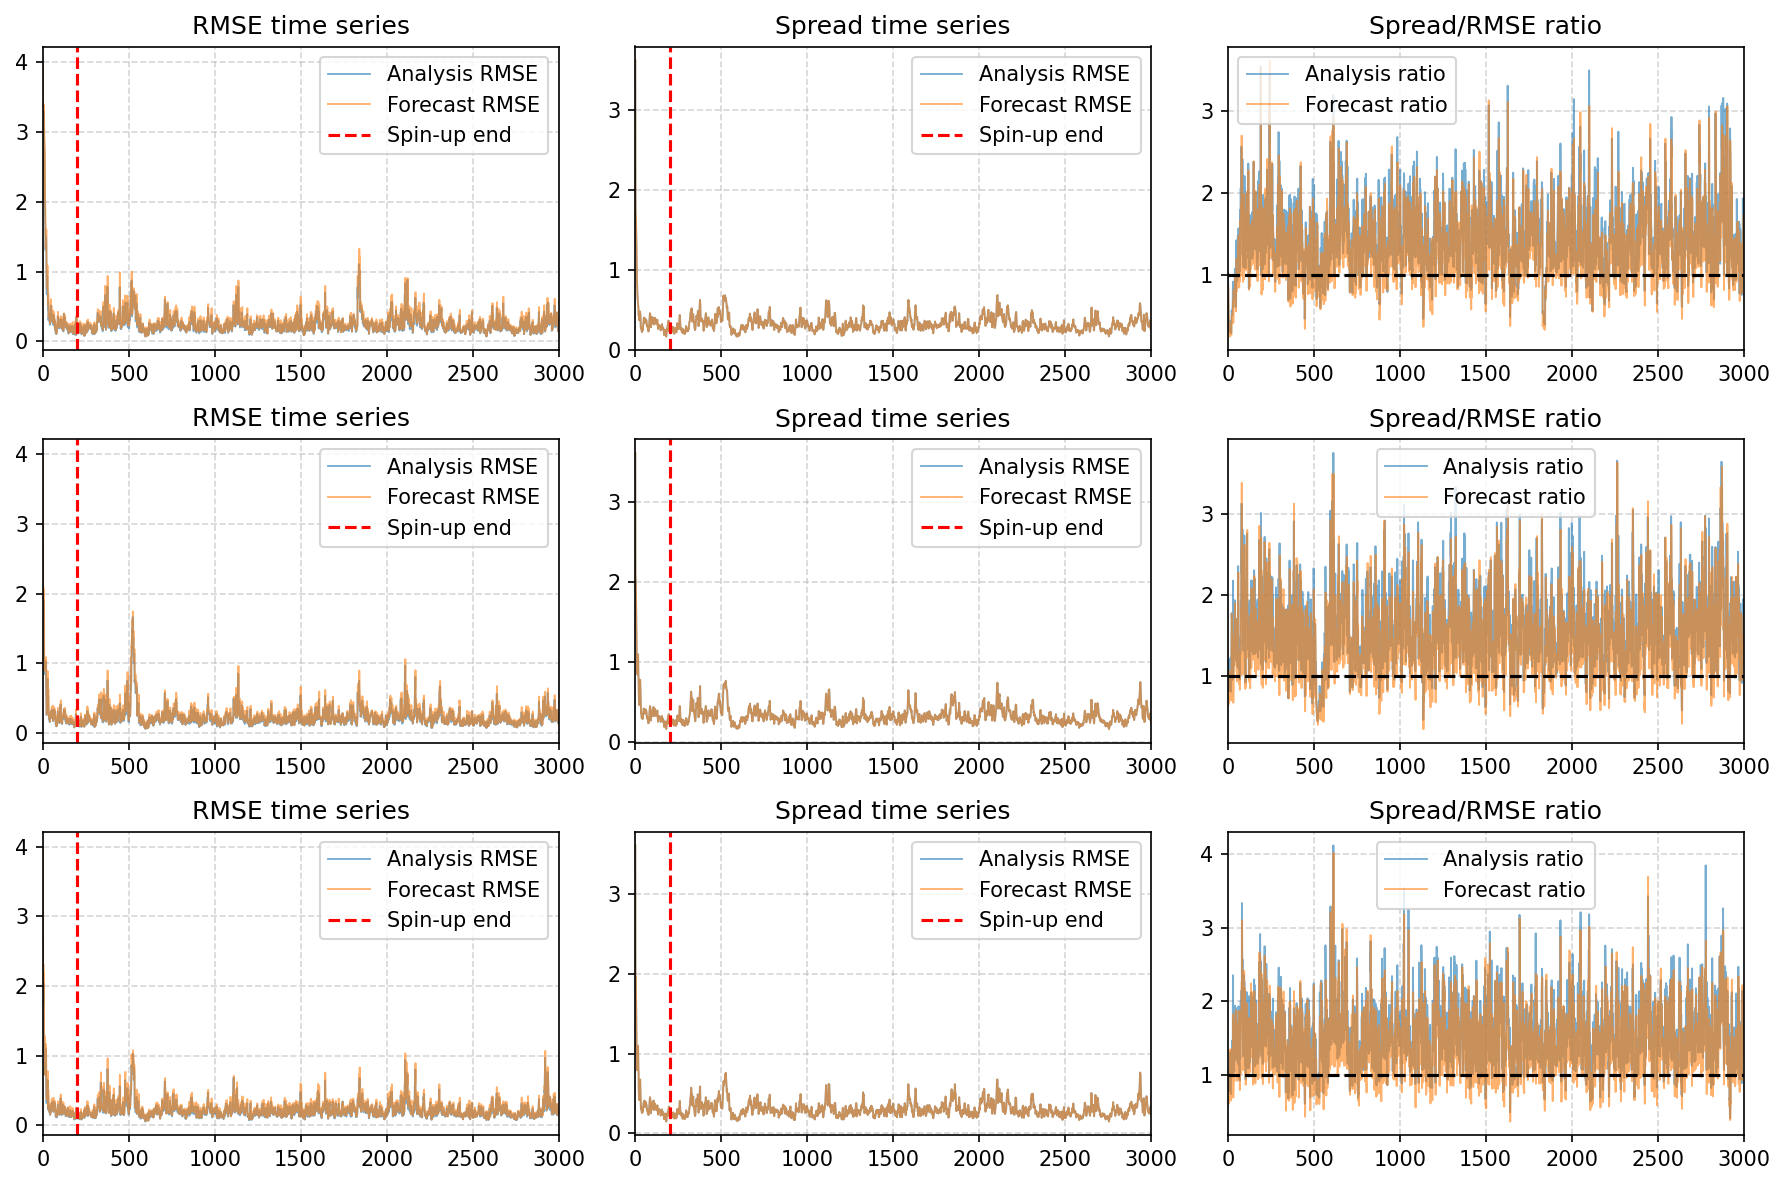

In [20]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import os

# === Settings ===

#filename  = "LETKF_Paper_Nature_Freq4_Den1.0_Type3_ObsErr5_Nens80_NTemp3_alpha2_NOGEC_80k_series.npz"
err = 5
Nens = 80
alpha = 2
prespinup = 100
inflation = 1.0

spinup    = 200   # cycles to discard as spin-up
limit = 3000
fig, axes = plt.subplots(3, 3, figsize=(12, 8), dpi=150)
for i in range(0,3):
    
    #filename = f"LETKF_Paper_Nature_Freq4_Den1.0_Type3_ObsErr{err}_Nens{Nens}_NTemp{i+1}_alpha{alpha}_NOGEC_80k_series.npz"
    filename = f"LETKF_Paper_Nature_Freq4_Den1.0_Type3_ObsErr{err}_Nens{Nens}_NTemp{i+1}_alpha{alpha}_NOGEC_40k_Prespinup{prespinup}_inf{inflation}.npz"
    print(f"Processing file: {filename}")
    # === Load file ===
    data = np.load(os.path.join(base_path, filename), allow_pickle=True)
    rmse_a = data["series_analysis_rmse"][0:limit]
    rmse_f = data["series_forecast_rmse"][0:limit]
    sprd_a = data["series_analysis_sprd"][0:limit]
    sprd_f = data["series_forecast_sprd"][0:limit]

    # === Diagnostics ===
    ratio_a = sprd_a / rmse_a
    ratio_f = sprd_f / rmse_f


    # === Plots ===
    

    # Time series RMSE
    axes[i,0].plot(rmse_a, label="Analysis RMSE", alpha=0.6, linewidth=0.9)
    axes[i,0].plot(rmse_f, label="Forecast RMSE", alpha=0.6, linewidth=0.9)
    axes[i,0].axvline(spinup, color="red", linestyle="--", label="Spin-up end")
    axes[i,0].set_title("RMSE time series")
    axes[i,0].legend()
    axes[i,0].grid(True, linestyle="--", alpha=0.5)
    axes[i,0].set_xlim(0, limit)

    # Time series SPREAD
    axes[i,1].plot(sprd_a, label="Analysis RMSE", alpha=0.6, linewidth=0.9)
    axes[i,1].plot(sprd_f, label="Forecast RMSE", alpha=0.6, linewidth=0.9)
    axes[i,1].axvline(spinup, color="red", linestyle="--", label="Spin-up end")
    axes[i,1].set_title("Spread time series")
    axes[i,1].legend()
    axes[i,1].grid(True, linestyle="--", alpha=0.5)
    axes[i,1].set_xlim(0, limit)

    # Spread/RMSE ratio
    axes[i,2].plot(ratio_a, label="Analysis ratio", alpha=0.6, linewidth=0.9)
    axes[i,2].plot(ratio_f, label="Forecast ratio", alpha=0.6, linewidth=0.9)
    axes[i,2].axhline(1.0, color="black", linestyle="--")
    axes[i,2].set_title("Spread/RMSE ratio")
    axes[i,2].legend()
    axes[i,2].grid(True, linestyle="--", alpha=0.5)
    axes[i,2].set_xlim(0, limit)

plt.tight_layout()
plt.show()


In [12]:
np.nanmax(sprd_a-sprd_f)

0.0